In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso,RidgeCV,ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score
import scipy
import xgboost as xgb
import pylab
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
import pydot

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
house = pd.read_csv('C://Users/liuleo/Documents/Kaggle/housesalesprediction/kc_house_data.csv')

In [3]:
# check if imputing applied on all the desired columns
for col in house.columns.values:
    if house[col].isnull().values.any():
        print col

In [4]:
house['build_age'] = house['yr_built'].apply(lambda x : 2015-x)
house['renovated_flag'] = house['yr_renovated'].apply(lambda x : 1 if x != 0  else 0)

house['renovated_vintage'] = house['yr_renovated'] - house['yr_built']
house['renovated_vintage'] = house['renovated_vintage'].apply(lambda x : x if x>=0 else 120)


house['renovated_age'] =  house['yr_renovated'].apply(lambda x : 120 if x==0 else 2015-x )

In [5]:
check = house.columns.to_series().groupby(house.dtypes).groups
check

{dtype('int64'): Index([u'id', u'bedrooms', u'sqft_living', u'sqft_lot', u'waterfront', u'view',
        u'condition', u'grade', u'sqft_above', u'sqft_basement', u'yr_built',
        u'yr_renovated', u'zipcode', u'sqft_living15', u'sqft_lot15',
        u'build_age', u'renovated_flag', u'renovated_vintage',
        u'renovated_age'],
       dtype='object'),
 dtype('float64'): Index([u'price', u'bathrooms', u'floors', u'lat', u'long'], dtype='object'),
 dtype('O'): Index([u'date'], dtype='object')}

In [6]:
OTHER_CATEGORIES = "OTHER_CATEGORIES"
SEPARATOR = "_"

CATEGORIES_REC_FEATURES_DICT = {
    'waterfront': [1],
}

def create_column_name(col_name, suffix):
    return '{}{}{}'.format(col_name, SEPARATOR, suffix)


cat_cols = ['waterfront']

for feature, values_to_dummy in CATEGORIES_REC_FEATURES_DICT.iteritems():
    print 'Dummy feature %s'%(feature)
    print 'The values to dummy',values_to_dummy
    for value in values_to_dummy:
        new_col = create_column_name(feature,value)
        house[new_col] = house[feature].apply(lambda x : 1 if x==value else 0)
    new_col = create_column_name(feature,OTHER_CATEGORIES)
    house[new_col] = house[feature].apply(lambda x: 0 if x in values_to_dummy else 1)
    house.drop(feature,axis=1,inplace=True)

for col in cat_cols:
    new_col = create_column_name(col,OTHER_CATEGORIES)
    house.drop(new_col,axis=1,inplace=True)

Dummy feature waterfront
The values to dummy [1]


In [7]:
USELESS_COLS = ['date','zipcode','yr_built','yr_renovated']
for col in USELESS_COLS:
    house.drop(col, axis=1, inplace=True)

In [ ]:
g = sns.pairplot(house[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], palette='afmhot',size=4)
g.set(xticklabels=[])

In [ ]:
corrs = house.corr()
plt.figure(figsize=(10,5))
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, mask=mask)

In [8]:
ALL_TARGETS = ['price']
IDS = ['id']
feature_columns = [col for col in house if col not in IDS and col not in ALL_TARGETS]
feature_columns = np.concatenate([IDS, feature_columns])

In [9]:
train, test = train_test_split(house,train_size=0.72,random_state=27)

print('Train data has %i rows and %i columns'%(train.shape[0], train.shape[1]))
print('Test data has %i rows and %i columns'%(test.shape[0], test.shape[1]))

Train data has 15561 rows and 21 columns
Test data has 6052 rows and 21 columns


In [10]:
COLS_TO_DROP = ALL_TARGETS + IDS  

X_train = train.drop(COLS_TO_DROP,axis=1)
X_test = test.drop(COLS_TO_DROP,axis=1)

In [11]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Define gini and normalized gini functions

In [12]:
def plotLorentz(tableIn, colLoss, distName='',display=True):
    
    tableTemp = tableIn[[colLoss]].copy(deep=True)
    tableTemp['colLossLorentz'] = tableTemp[colLoss].copy(deep=True)
    return plotGini(tableTemp,colLoss, 'colLossLorentz', distName, display)

def plotGini(tableIn, colScore, colLoss, modeleName='', display=True):
    """
        A function to plot a single Lorentz curve
        It will also plot the 'line of equality' and the Lorentz curve corresponding to the perfect model
    """

    tableScore = tableIn[[colScore, colLoss]].copy(deep=True)

    
    colPrem = 'unit'
    tableScore[colPrem] = 1

    tableScore.sort_values(colScore, inplace=True)

    tableScore[colPrem] = tableScore[colPrem] * 1. / tableScore[colPrem].sum()
    tableScore['premCum'] = tableScore[colPrem].cumsum()

    tableScore['lossCum'] = tableScore[colLoss].cumsum() * 1. / tableScore[colLoss].sum()

    coefGini = ((tableScore['premCum'] - tableScore['lossCum']) * tableScore[colPrem]).sum() * 2

    if colLoss != 'colLossLorentz':
        # We build the Lorentz curve (perfect order) to print it if we print a Gini curve for one price
        seriesLoss = sorted(tableScore[colLoss] / tableScore[colLoss].sum())
        seriesLoss = np.cumsum(seriesLoss)

    if colLoss != 'colLossLorentz':
        coefGini = coefGini / plotLorentz(tableIn, colLoss,display=False)

    if display:
        plt.figure(figsize=(10, 6))
        plt.plot(tableScore['premCum'], tableScore['lossCum'], label='Real Model')
        plt.plot([0, 1], [0, 1], label='Random Model')

        plt.title("Gini Curve" + modeleName, fontsize=22)


        plt.text(0.75, 0.01, 'Normalized Gini = ' + str(np.round(coefGini,3)), fontsize=12)
        plt.axis([0, 1, -0.1, 1])
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.yticks(np.arange(0, 1.1, 0.1))
       
        plt.xlabel('Proportion of values ranked by predicted values', fontsize=18)


        if colScore != colLoss:
            plt.plot([x * 1. / len(tableScore) for x in range(len(tableScore))], seriesLoss, ls='--', label='Perfect Model')

        plt.ylabel('Proportion of values ranked by actual values', fontsize=18)
        plt.legend(loc='upper left')
        plt.show()
        
    return coefGini


In [13]:
def compute_gini(actual,pred,weight=None):
    pdf= pd.DataFrame(scipy.vstack([actual,pred]).T,columns=['Actual','Predicted'],)
    pdf= pdf.sort_values('Predicted')
    if weight is None:
        pdf['Weight'] = 1.0

    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'])
    pdf['CummulativeWeightedActual'] = np.cumsum(pdf['Actual']*pdf['Weight'])
    TotalWeight = sum(pdf['Weight'])
    Numerator = sum(pdf['CummulativeWeightedActual']*pdf['Weight'])
    Denominator = sum(pdf['Actual']*pdf['Weight']*TotalWeight)
    Gini = 1.0 - 2.0 * Numerator/Denominator
    return Gini

def normalized_gini(actual,pred,weight=None):
    """
    Plot a lift chart to compare regression model performance on specific segments
    """
    pdf= pd.DataFrame(scipy.vstack([actual,pred]).T,columns=['Actual','Predicted'],)
    pdf= pdf.sort_values(by='Predicted')
    if weight is None:
        pdf['Weight'] = 1.0
    
    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'])
    pdf['CummulativeWeightedActual'] = np.cumsum(pdf['Actual']*pdf['Weight'])
    TotalWeight = sum(pdf['Weight'])
    Numerator = sum(pdf['CummulativeWeightedActual']*pdf['Weight'])
    Denominator = sum(pdf['Actual']*pdf['Weight']*TotalWeight)
    Gini = 1.0 - 2.0 * Numerator/Denominator
    NormalizedGini = Gini/ compute_gini(pdf['Actual'],pdf['Actual'])
    return NormalizedGini

## Define lift function 

In [14]:
def liftChart(actual,pred,weight=None,n=10):
    pdf= pd.DataFrame(scipy.vstack([actual,pred]).T,columns=['Actual','Predicted'],)
    pdf= pdf.sort_values(by='Predicted')
    if weight is None:
        pdf['Weight'] = 1.0

    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'])
    TotalWeight = sum(pdf['Weight'])
    pdf['PredictedDecile'] = np.round(pdf['CummulativeWeight']*n /TotalWeight + 0.5,decimals=0)
    pdf['PredictedDecile'][pdf['PredictedDecile'] < 1.0] = 1.0
    pdf['PredictedDecile'][pdf['PredictedDecile'] > n] = n 
    pdf['WeightedPrediction'] = pdf['Predicted']*pdf['Weight']
    pdf['WeightedActual'] = pdf['Actual']*pdf['Weight']
   
    
    lift_df = pdf.groupby('PredictedDecile').agg({'WeightedPrediction': [np.sum,np.mean,pd.Series.median],
                                                  'WeightedActual':[np.sum,np.mean,pd.Series.median],
                                                 'PredictedDecile':np.size})
    
    lift_df.columns = ['_'.join(col).strip() for col in lift_df.columns.values]
    lift_df.rename(columns={'PredictedDecile_size':'Group_Size'}, inplace=True)

    lift_df['AverageError'] = lift_df['WeightedPrediction_mean']/lift_df['WeightedActual_mean']
    lift_df['MedianError'] = lift_df['WeightedPrediction_median']/lift_df['WeightedActual_median']

    d = pd.DataFrame(lift_df.index)
    p = lift_df['WeightedPrediction_mean']
    a = lift_df['WeightedActual_mean']
    pylab.plot(d,p,label='Predicted',color='blue',marker='o')
    pylab.plot(d,a,label='Actual',color='red',marker='d')
    
    pylab.legend(['Predicted','Actual'], loc=2)
    pylab.title('Model Performance Lift Chart')
    pylab.xlabel('Predicted Decile')
    pylab.ylabel('Actual vs. Predicted')
    pylab.grid()
    pylab.show()
    
    #return lift_df

## Define feature importance function

In [15]:
def get_importance(_bst, _importance_type):
    # if it's weight, then omap stores the number of missing values
    fmap = ''
    if _importance_type == 'weight':
        # do a simpler tree dump to save time
        trees = _bst.get_dump(fmap, with_stats=False)

        fmap = {}
        for tree in trees:
            for line in tree.split('\n'):
                # look for the opening square bracket
                arr = line.split('[')
                # if no opening bracket (leaf node), ignore this line
                if len(arr) == 1:
                    continue

                # extract feature name from string between []
                fid = arr[1].split(']')[0].split('<')[0]

                if fid not in fmap:
                    # if the feature hasn't been seen yet
                    fmap[fid] = 1
                else:
                    fmap[fid] += 1

        return fmap

    else:
        trees = _bst.get_dump(fmap, with_stats=True)

        _importance_type += '='
        fmap = {}
        gmap = {}
        for tree in trees:
            for line in tree.split('\n'):
                # look for the opening square bracket
                arr = line.split('[')
                # if no opening bracket (leaf node), ignore this line
                if len(arr) == 1:
                    continue

                # look for the closing bracket, extract only info within that bracket
                fid = arr[1].split(']')

                # extract gain or cover from string after closing bracket
                g = float(fid[1].split(_importance_type)[1].split(',')[0])

                # extract feature name from string before closing bracket
                fid = fid[0].split('<')[0]

                if fid not in fmap:
                    # if the feature hasn't been seen yet
                    fmap[fid] = 1
                    gmap[fid] = g
                else:
                    fmap[fid] += 1
                    gmap[fid] += g

        # calculate average value (gain/cover) for each feature
        for fid in gmap:
            gmap[fid] = gmap[fid] / fmap[fid]

        return gmap

## Grid search best parameters for Xgboost reg

In [26]:
results_test_xgb = test[['id','price']].copy()

target = 'price'
grid_parameters = {}

print("Start training with Grid Search")
print('Start Linear Regression training for target %s'%(target))

# max_delta_step need to be set to 0
xgbr = xgb.XGBRegressor(nthread=2,seed=27,max_depth=5,n_estimators=200,learning_rate=0.1,subsample=0.9,colsample_bylevel=0.9,
                       colsample_bytree=1,max_delta_step=0) #max_delta_step=0 max_delta_step set to 0
clf = GridSearchCV(xgbr,grid_parameters,scoring='r2',cv=3, verbose=1,n_jobs=1) # 'r2'

y_train = np.array(train[target])
clf.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_estimator_)

print("\n Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))

y_test = np.array(test[target])
y_true, y_pred = y_test, clf.predict(X_test)

print("Scores on the evaluation dataset")

# The coefficients
#print('Coefficients: \n', clf.best_estimator_.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_true,y_pred))
# The root mean squared error
print("Root Mean squared error: %.2f" % mean_squared_error(y_true,y_pred)**0.5)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_true, y_pred))


print 'gini {}'.format(compute_gini(y_true, y_pred))
print 'normalized_gini {}'.format(normalized_gini(y_true, y_pred))

cols = ['pred_price']

proba_df = pd.DataFrame(data=y_pred,index=test[feature_columns].index,columns=cols)
results_test_xgb = pd.concat([results_test_xgb,proba_df],axis=1)

Start training with Grid Search
Start Linear Regression training for target price
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s finished


Best parameters set found on development set:

XGBRegressor(base_score=0.5, colsample_bylevel=0.9, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=200, nthread=2,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9)

 Grid scores on development set:
0.890 (+/-0.001) for {}
Scores on the evaluation dataset
Mean squared error: 15033604323.67
Root Mean squared error: 122611.60
Variance score: 0.90
gini 0.300165123943
normalized_gini 0.96037743275


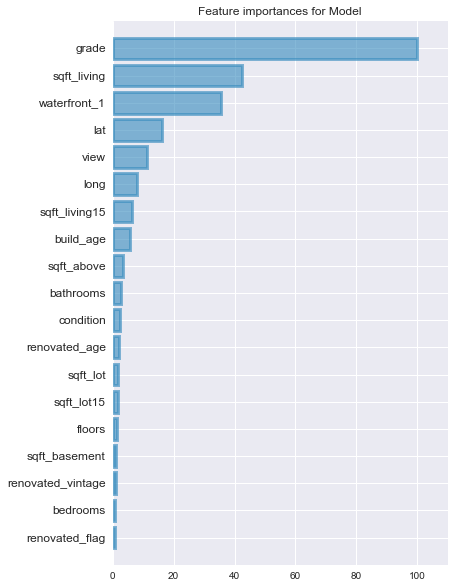

In [29]:
feature_importances_data = []
features = X_test.columns
for feature_name, feature_importance in get_importance(clf.best_estimator_.booster(), 'gain').iteritems():
    feature_importances_data.append({
            'feature': feature_name,
            'importance': feature_importance
        })

feature_importances = pd.DataFrame(feature_importances_data)

feature_importances['abs_imp'] = feature_importances['importance'].apply(lambda x: abs(x))
feature_importances_sort = feature_importances.sort_values(by='abs_imp',ascending=False)
feature_importances_sort['relative_imp'] = 100.0 * (feature_importances_sort['abs_imp'] / feature_importances_sort['abs_imp'].max())
feature_importances_sort = feature_importances_sort[::-1].reset_index(drop=True)

plt.figure(figsize=(6, 10))
plt.title("Feature importances for Model")
plt.barh(feature_importances_sort.index, feature_importances_sort['relative_imp'],
         color='#348ABD', align="center", lw='3', edgecolor='#348ABD', alpha=0.6)
plt.yticks(feature_importances_sort.index, feature_importances_sort['feature'], fontsize=12,)
plt.ylim([-1, feature_importances_sort.index.max()+1])
plt.xlim([0, feature_importances_sort['relative_imp'].max()*1.1])
plt.show()

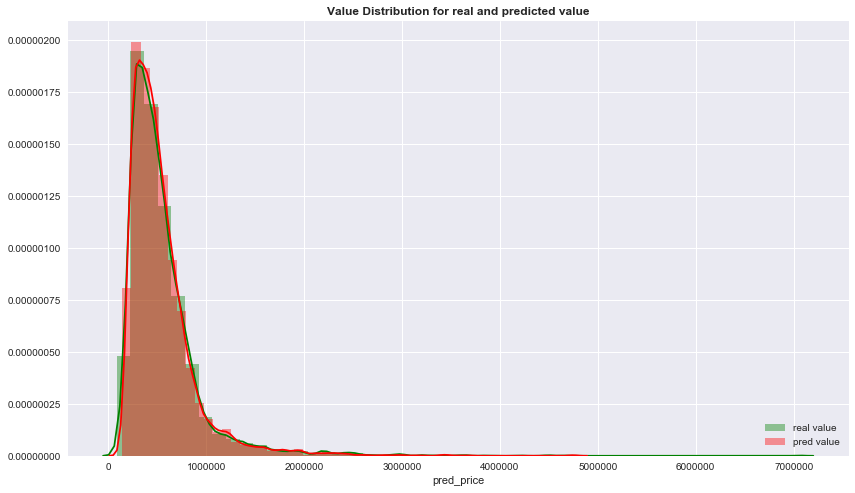

In [35]:
plt.figure(figsize=(14, 8))
plt.title('Value Distribution for real and predicted value', fontsize=12, fontweight="bold")
sns.distplot(results_test_xgb.price, color='green',label='real value')
sns.distplot(results_test_xgb.pred_price, color='red', label='pred value')
plt.legend(loc="lower right")

## Define cross-validation function

In [40]:
def kfold_prediction(data, features, target, estimator, nfolds, column_stratify, predict_on_train, 
                     display_feature_importance):

    # DataFrame to store the results of KFold:
    result_KFold = pd.DataFrame([],columns=['Fold','MSE_test', 'EVS_test','MAE_test','R2_score_test', 'Gini_test'])
    
    prob_of = target+'_prediction'
    split_id = 'id'
    
    results_cv_targeting = pd.DataFrame([], columns=[split_id, target, 'fold', prob_of])
    
    # Prepare Cross-Validation
    if column_stratify is not None:
        # We use a stratify KFold so we need to give the vector used for stratification:
        print "\nStratified KFold using the column:", column_stratify
        y_strat = data[column_stratify]
        print "Values for stratification: ", pd.unique(y_strat.ravel())
        kf = StratifiedKFold(n_splits=nfolds, shuffle=False)

    # Run KFold
    print "Number of folds :", kf.get_n_splits(data, data[column_stratify])

    numfold = 1

    # Running kFolds validation for cost
    for train_index, test_index in kf.split(data, data[column_stratify]):
        print "\n------ FOLD nb ", numfold, " ------"
        print "Length training set:", len(train_index)
        print "Length test set:", len(test_index)

        X_train = data[features].iloc[train_index]
        X_test = data[features].iloc[test_index]

        y_train = data[target].iloc[train_index]
        y_test = data[target].iloc[test_index]
        
        temp = data[[split_id, target]].iloc[test_index].copy()
        temp['fold'] = numfold
        
        # We fit the estimator using training set
        estimator.fit(X_train, y_train)
        
        # --- Display graph with feature importance ---
        if display_feature_importance:
            #feat_imp = pd.Series(estimator.booster().get_fscore()).sort_values(ascending=False)
            feat_imp = pd.Series(get_importance(estimator.booster(), 'gain')).sort_values(ascending=False)
            plt.figure(figsize=(14, 8))
            feat_imp[:50].plot(kind='bar', title='Feature Importances')
            plt.ylabel('Feature Importance Score')
            plt.show()

        # Predict target on training set
        #if predict_on_train:
        #    data[target+'_prediction'].iloc[train_index] = estimator.predict(X_train)

        # # Predict target on test set
        _pred_value = estimator.predict(X_test)
        pred_values = pd.DataFrame(data=_pred_value, index=X_test.index, columns=[prob_of])
        temp = temp.join(pred_values, how='left')
        results_cv_targeting = results_cv_targeting.append(temp)
        
        # # EVALUATION OF PREDICTIONS
        
        # # Mean squared errors
        #mse_train = mean_squared_error(y_train, data[target+'_prediction'].ix[train_index])
        mse_test = mean_squared_error(y_test,_pred_value)

        # # Explained variance score
        #evs_train = explained_variance_score(data[target].ix[train_index], data[target+'_prediction'].ix[train_index])
        evs_test = explained_variance_score(y_test, _pred_value)

        # # Mean Absolute Errors
        #mae_train = mean_absolute_error(data[target].ix[train_index], data[target+'_prediction'].ix[train_index])
        mae_test = mean_absolute_error(y_test, _pred_value)

        # # R2 score
        #r2_train = r2_score(data[target].ix[train_index], data[target+'_prediction'].ix[train_index])
        r2_test = r2_score(y_test, _pred_value)
        
        plt.figure(figsize=(14, 8))
        plt.title('Value Distribution for real and predicted value', fontsize=12, fontweight="bold")
        sns.distplot(y_test, color='green',label='real value')
        sns.distplot(_pred_value, color='red', label='pred value')
        plt.legend(loc="lower right")

        # # Gini coefficient
        #gini_train = plotGini(data.ix[train_index], colScore=target+'_prediction', colLoss=target,
        #                           modeleName='Gini curve for training set', display=True)
        gini_test = plotGini(temp, colScore=target+'_prediction', colLoss=target,modeleName='Gini curve for test set', 
                             display=True)
        
        liftChart(y_test, _pred_value, n=10)

        print "mse_test : {}".format(mse_test)
        print "root of mse_test : {}".format(mse_test**0.5)
        print "r2_score_test : {}".format(r2_test)
        print "gini_test : {}".format(gini_test)
        print "mae_test : {}".format(mae_test)
        print "evs_test : {}".format(evs_test)
        

        # # We save the results of prediction:
        #results = [numfold, mse_train, mse_test, evs_train, evs_test, mae_train, mae_test, r2_train, r2_test,gini_train, gini_test]
        results = pd.DataFrame(data=[[numfold, mse_test, evs_test,mae_test,r2_test, gini_test]], 
                               columns=['Fold','MSE_test', 'EVS_test','MAE_test','R2_score_test', 'Gini_test'])
        #print "index is : {}".format(len(result_KFold)+1)
        result_KFold = result_KFold.append(results)
        

        # # We increment the fold counter
        numfold += 1
        
    return result_KFold, results_cv_targeting


Stratified KFold using the column: price
Values for stratification:  [  221900.   538000.   180000. ...,   610685.  1007500.   402101.]
Number of folds : 3

------ FOLD nb  1  ------
Length training set: 12310
Length test set: 9303


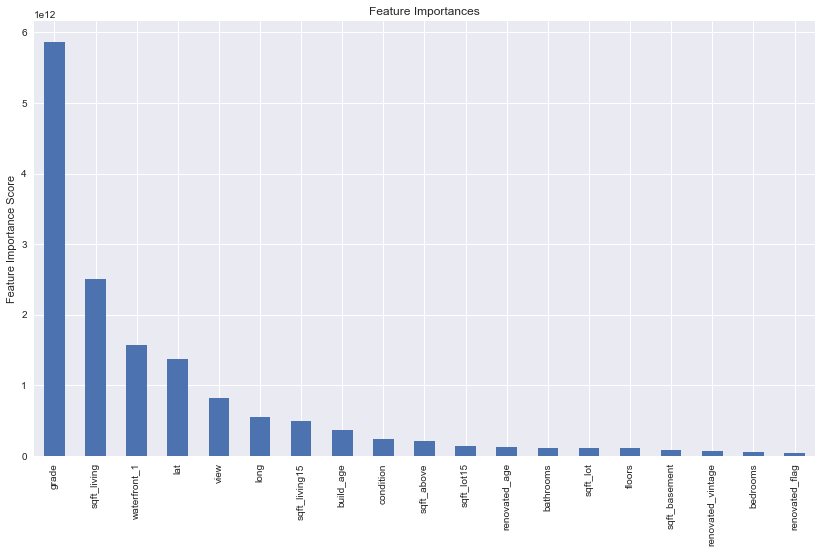

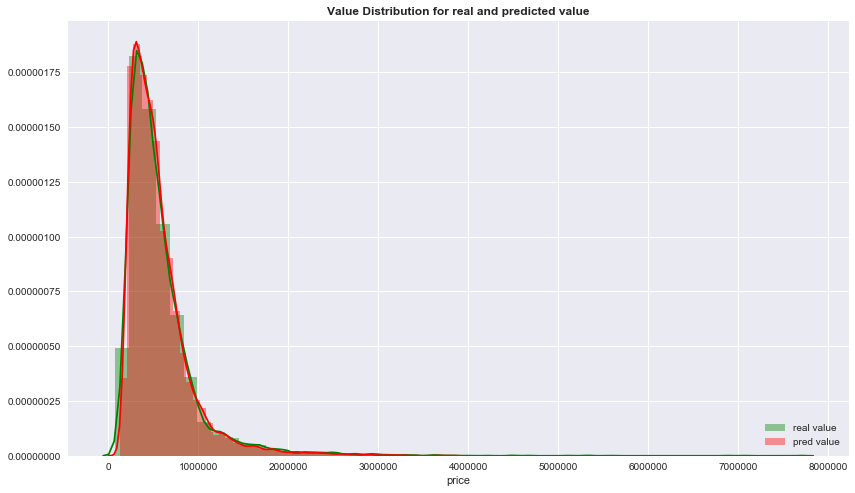

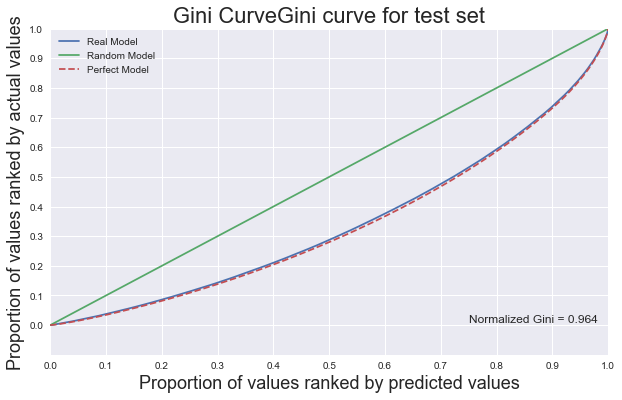

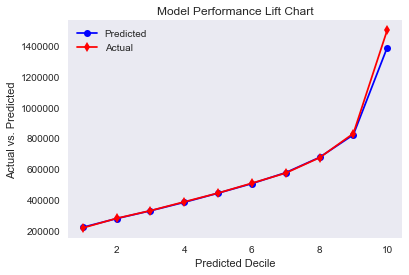

mse_test : 24686054576.4
root of mse_test : 157117.963888
r2_score_test : 0.86910683814
gini_test : 0.963721257608
mae_test : 75422.0652931
evs_test : 0.869884732561

------ FOLD nb  2  ------
Length training set: 15070
Length test set: 6543


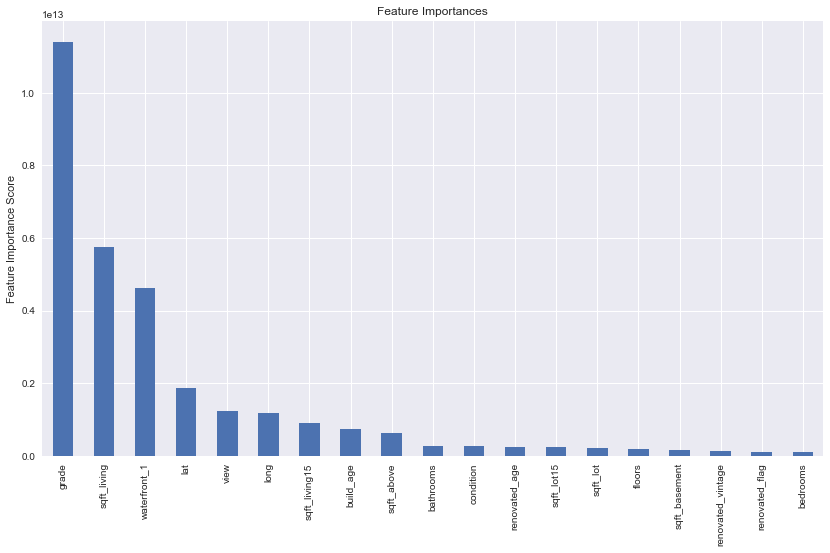

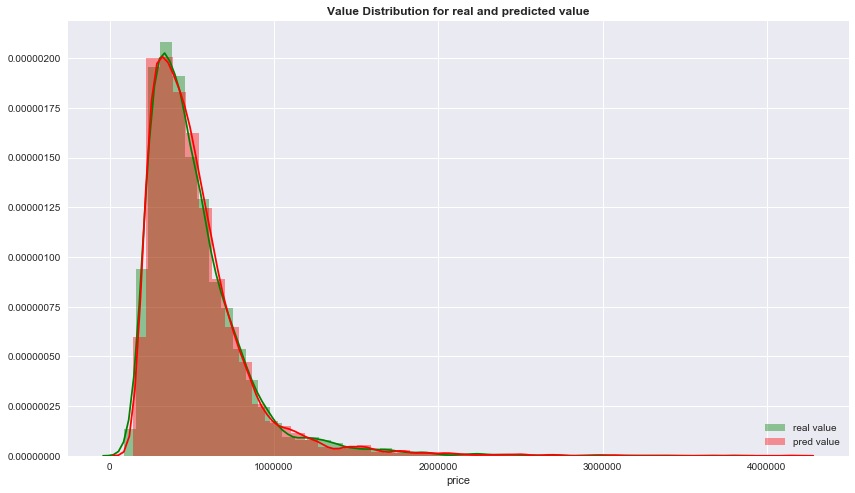

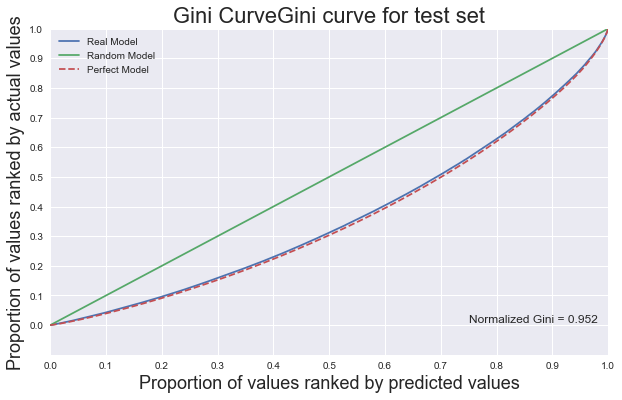

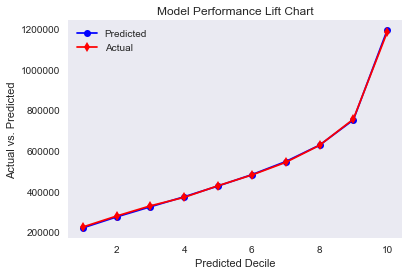

mse_test : 11444603466.7
root of mse_test : 106979.453479
r2_score_test : 0.885401282212
gini_test : 0.95233923761
mae_test : 64980.8405357
evs_test : 0.88540130393

------ FOLD nb  3  ------
Length training set: 15846
Length test set: 5767


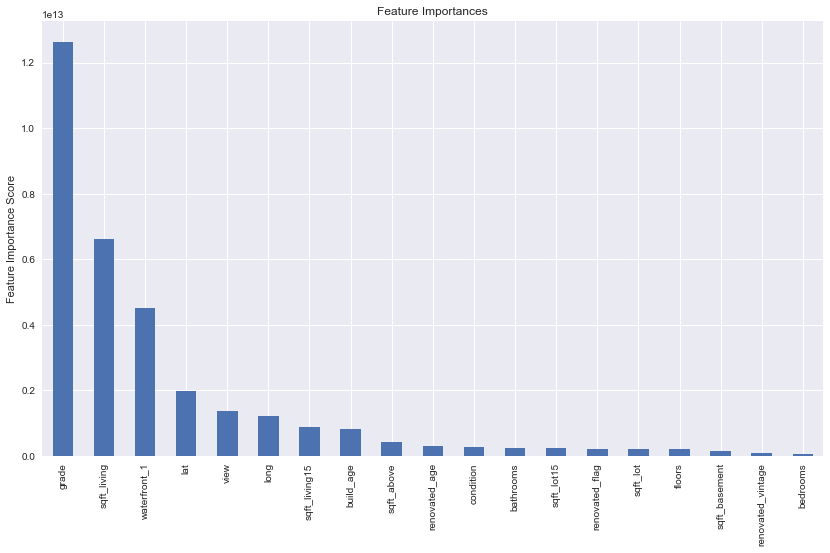

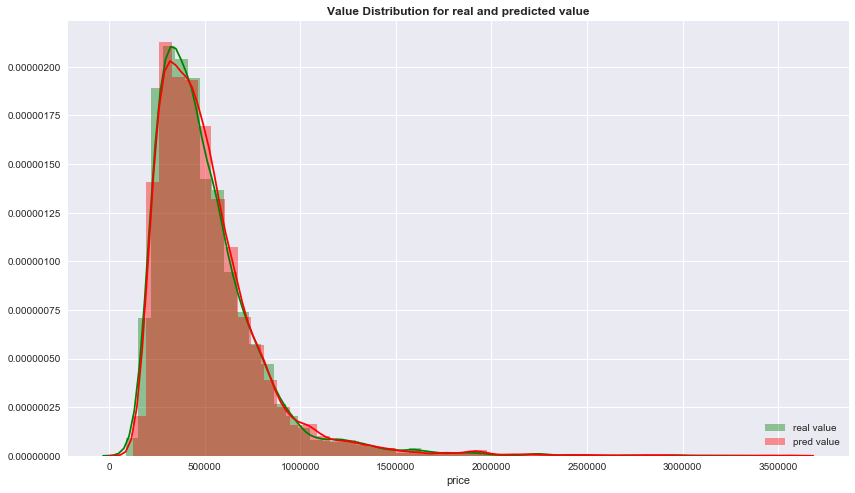

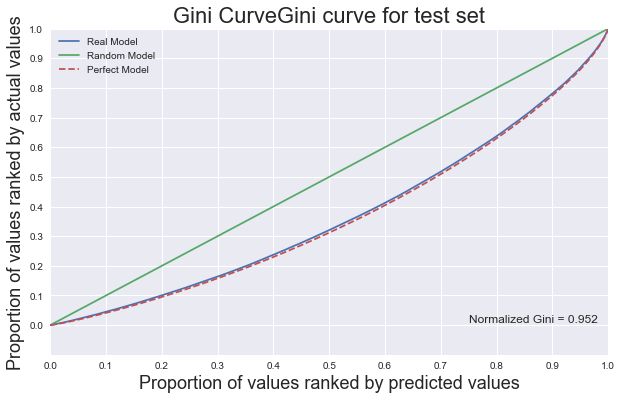

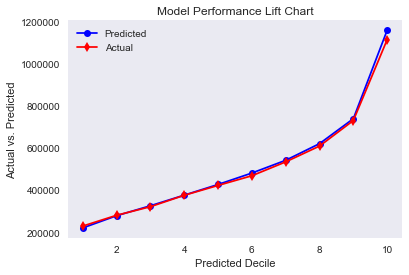

mse_test : 10696378404.9
root of mse_test : 103423.297206
r2_score_test : 0.873293050542
gini_test : 0.951767297407
mae_test : 62293.4004262
evs_test : 0.874126940486


In [41]:

xgb_model = xgb.XGBRegressor(nthread=2,seed=27,max_depth=5,n_estimators=200,learning_rate=0.1,subsample=0.9,colsample_bylevel=0.9,
                       colsample_bytree=1,max_delta_step=0)

feature_cols = X_train.columns.values

nfolds = 3
predict_on_train = False
display_feature_importance = True


target = 'price'
column_stratify = "price"  # Use None if no stratification

agg_results, results = kfold_prediction(house, feature_cols, target, xgb_model, nfolds, column_stratify, predict_on_train, 
                 display_feature_importance)

In [42]:
agg_results

,Fold,MSE_test,EVS_test,MAE_test,R2_score_test,Gini_test
0,1,2.468605e+10,0.869885,75422.065293,0.869107,0.963721
0,2,1.144460e+10,0.885401,64980.840536,0.885401,0.952339
0,3,1.069638e+10,0.874127,62293.400426,0.873293,0.951767


# Diffe Regression models

## Decision tree regression

In [16]:
results_test_rf = test[['id','price']].copy()

target = 'price'
grid_parameters = {'max_depth' : [6]}

print("Start training with Grid Search")
print('Start Decision Tree Regression training for target %s'%(target))

dt = DecisionTreeRegressor( min_samples_split=10,min_samples_leaf=5)
clf = GridSearchCV(dt,grid_parameters,scoring='neg_mean_squared_error',cv=3, verbose=1) # 'r2'

y_train = np.array(train[target])
clf.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_estimator_)

print("\n Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))

y_test = np.array(test[target])
y_true, y_pred = y_test, clf.predict(X_test)

print("Scores on the evaluation dataset")

# The coefficients
#print('Coefficients: \n', clf.best_estimator_.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_true,y_pred))
# The root mean squared error
print("Root Mean squared error: %.2f" % mean_squared_error(y_true,y_pred)**0.5)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_true, y_pred))


print 'gini {}'.format(compute_gini(y_true, y_pred))
print 'normalized_gini {}'.format(normalized_gini(y_true, y_pred))

cols = ['pred_price']

proba_df = pd.DataFrame(data=y_pred,index=test[feature_columns].index,columns=cols)
results_test_rf = pd.concat([results_test_rf,proba_df],axis=1)



Start training with Grid Search
Start Decision Tree Regression training for target price
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters set found on development set:

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

 Grid scores on development set:
-33361294565.424 (+/-394165889.232) for {'max_depth': 6}
Scores on the evaluation dataset
Mean squared error: 36096699782.11
Root Mean squared error: 189991.32
Variance score: 0.76
gini 0.281033470569
normalized_gini 0.899165763952


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


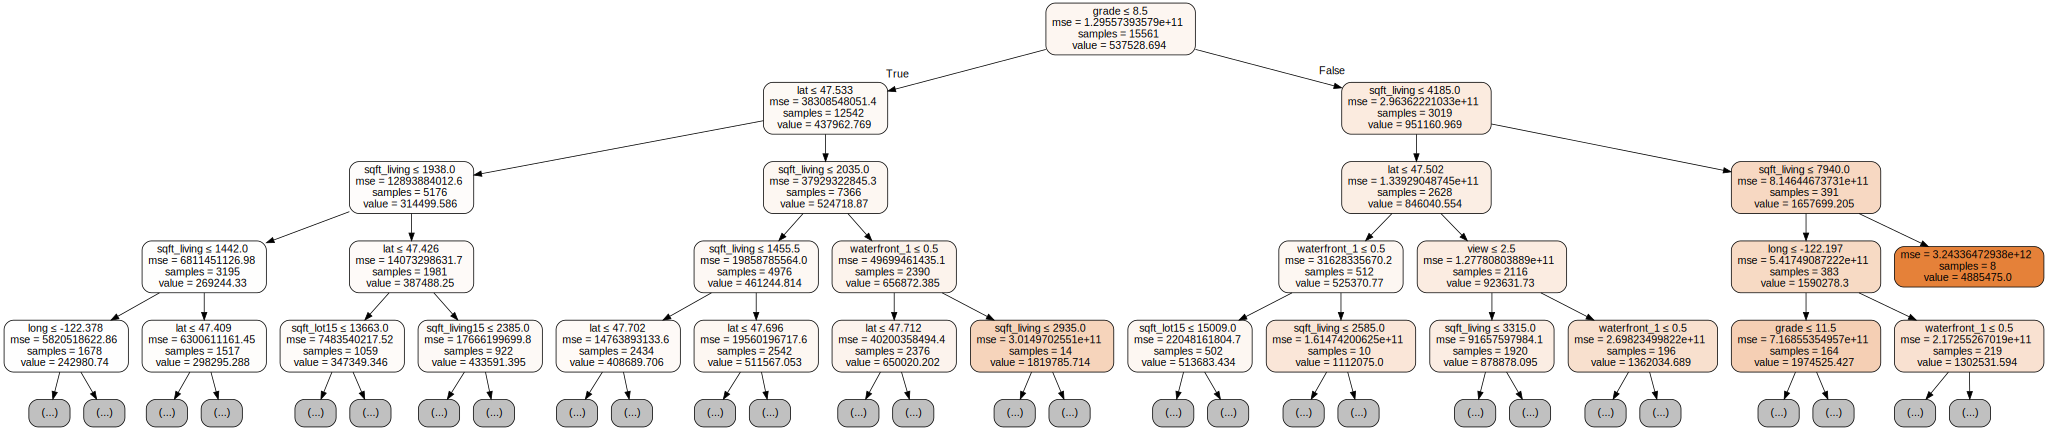

In [25]:
dot_data = export_graphviz(clf.best_estimator_, out_file=None,max_depth=4,feature_names=X_train.columns.values.tolist(), 
                                filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)
graph

## Linear regression

In [ ]:
results_test = test[['id','price']].copy()

target = 'price'
grid_parameters = {'normalize':['True','False']}

print("Start training with Grid Search")
print('Start Linear Regression training for target %s'%(target))

regr = LinearRegression()
clf = GridSearchCV(regr,grid_parameters,scoring='neg_mean_squared_error',cv=3, verbose=1,n_jobs=1) #'r2'

y_train = np.array(train[target])
clf.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_estimator_)

print("\n Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))

y_test = np.array(test[target])
y_true, y_pred = y_test, clf.predict(X_test)

print("Scores on the evaluation dataset")

# The coefficients
print('Coefficients: \n', clf.best_estimator_.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_true,y_pred))
# The root mean squared error
print("Root Mean squared error: %.2f" % mean_squared_error(y_true,y_pred)**0.5)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_true, y_pred))


print 'gini {}'.format(compute_gini(y_true, y_pred))
print 'normalized_gini {}'.format(normalized_gini(y_true, y_pred))

cols = ['pred_price']

proba_df = pd.DataFrame(data=y_pred,index=test[feature_columns].index,columns=cols)
results_test = pd.concat([results_test,proba_df],axis=1)

## Ridge regression

In [ ]:
results_test_ridge = test[['id','price']].copy()


target = 'price'
grid_parameters = {'alpha':[1,0.1,0.01,0.001]}

print("Start training with Grid Search")
print('Start Linear Regression training for target %s'%(target))

rid = Ridge(normalize='True')
clf = GridSearchCV(rid,grid_parameters,scoring='neg_mean_squared_error',cv=3, verbose=1,n_jobs=1) #'r2'

y_train = np.array(train[target])
clf.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_estimator_)

print("\n Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))

y_test = np.array(test[target])
y_true, y_pred = y_test, clf.predict(X_test)

print("Scores on the evaluation dataset")

# The coefficients
print('Coefficients: \n', clf.best_estimator_.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_true,y_pred))
# The root mean squared error
print("Root Mean squared error: %.2f" % mean_squared_error(y_true,y_pred)**0.5)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_true, y_pred))


print 'gini {}'.format(compute_gini(y_true, y_pred))
print 'normalized_gini {}'.format(normalized_gini(y_true, y_pred))

cols = ['pred_price']

proba_df = pd.DataFrame(data=y_pred,index=test[feature_columns].index,columns=cols)
results_test_ridge = pd.concat([results_test_ridge,proba_df],axis=1)

## Lasso regression

In [ ]:
results_test_ridge = test[['id','price']].copy()

target = 'price'
grid_parameters = {'alpha':[1,0.1,0.01]}

print("Start training with Grid Search")
print('Start Linear Regression training for target %s'%(target))

las = Lasso(normalize=True)
clf = GridSearchCV(las,grid_parameters,scoring='neg_mean_squared_error',cv=3, verbose=1,n_jobs=1) # 'r2'

y_train = np.array(train[target])
clf.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_estimator_)

print("\n Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))

y_test = np.array(test[target])
y_true, y_pred = y_test, clf.predict(X_test)

print("Scores on the evaluation dataset")

# The coefficients
print('Coefficients: \n', clf.best_estimator_.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_true,y_pred))
# The root mean squared error
print("Root Mean squared error: %.2f" % mean_squared_error(y_true,y_pred)**0.5)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_true, y_pred))


print 'gini {}'.format(compute_gini(y_true, y_pred))
print 'normalized_gini {}'.format(normalized_gini(y_true, y_pred))

cols = ['pred_price']

proba_df = pd.DataFrame(data=y_pred,index=test[feature_columns].index,columns=cols)
results_test_ridge = pd.concat([results_test_ridge,proba_df],axis=1)

## Elastic net regression

In [ ]:
results_test_ela = test[['id','price']].copy()
#results_train = train[['id','price']].copy()

target = 'price'
grid_parameters = {'alpha':[1,0.1,0.01],'l1_ratio': [0.5,0.7]}

print("Start training with Grid Search")
print('Start Linear Regression training for target %s'%(target))

las = ElasticNet(normalize=True)
clf = GridSearchCV(las,grid_parameters,scoring='neg_mean_squared_error',cv=3, verbose=1,n_jobs=1) # 'r2'

y_train = np.array(train[target])
clf.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_estimator_)

print("\n Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))

y_test = np.array(test[target])
y_true, y_pred = y_test, clf.predict(X_test)

print("Scores on the evaluation dataset")

# The coefficients
print('Coefficients: \n', clf.best_estimator_.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_true,y_pred))
# The root mean squared error
print("Root Mean squared error: %.2f" % mean_squared_error(y_true,y_pred)**0.5)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_true, y_pred))


print 'gini {}'.format(compute_gini(y_true, y_pred))
print 'normalized_gini {}'.format(normalized_gini(y_true, y_pred))

cols = ['pred_price']

proba_df = pd.DataFrame(data=y_pred,index=test[feature_columns].index,columns=cols)
results_test_ela = pd.concat([results_test_ela,proba_df],axis=1)

## Random forest regression

In [43]:
results_test_rf = test[['id','price']].copy()

target = 'price'
grid_parameters = {'max_depth' : [6]}

print("Start training with Grid Search")
print('Start Linear Regression training for target %s'%(target))

las = RandomForestRegressor(n_estimators=150, min_samples_split=10,min_samples_leaf=5, n_jobs=2)
clf = GridSearchCV(las,grid_parameters,scoring='neg_mean_squared_error',cv=3, verbose=1,n_jobs=1) # 'r2'

y_train = np.array(train[target])
clf.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_estimator_)

print("\n Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))

y_test = np.array(test[target])
y_true, y_pred = y_test, clf.predict(X_test)

print("Scores on the evaluation dataset")

# The coefficients
#print('Coefficients: \n', clf.best_estimator_.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_true,y_pred))
# The root mean squared error
print("Root Mean squared error: %.2f" % mean_squared_error(y_true,y_pred)**0.5)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_true, y_pred))


print 'gini {}'.format(compute_gini(y_true, y_pred))
print 'normalized_gini {}'.format(normalized_gini(y_true, y_pred))

cols = ['pred_price']

proba_df = pd.DataFrame(data=y_pred,index=test[feature_columns].index,columns=cols)
results_test_rf = pd.concat([results_test_rf,proba_df],axis=1)

Start training with Grid Search
Start Linear Regression training for target price
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.4s finished


Best parameters set found on development set:

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

 Grid scores on development set:
-26025505507.797 (+/-811752834.291) for {'max_depth': 6}
Scores on the evaluation dataset
Mean squared error: 27947264829.33
Root Mean squared error: 167174.35
Variance score: 0.81
gini 0.288837098259
normalized_gini 0.924133447833


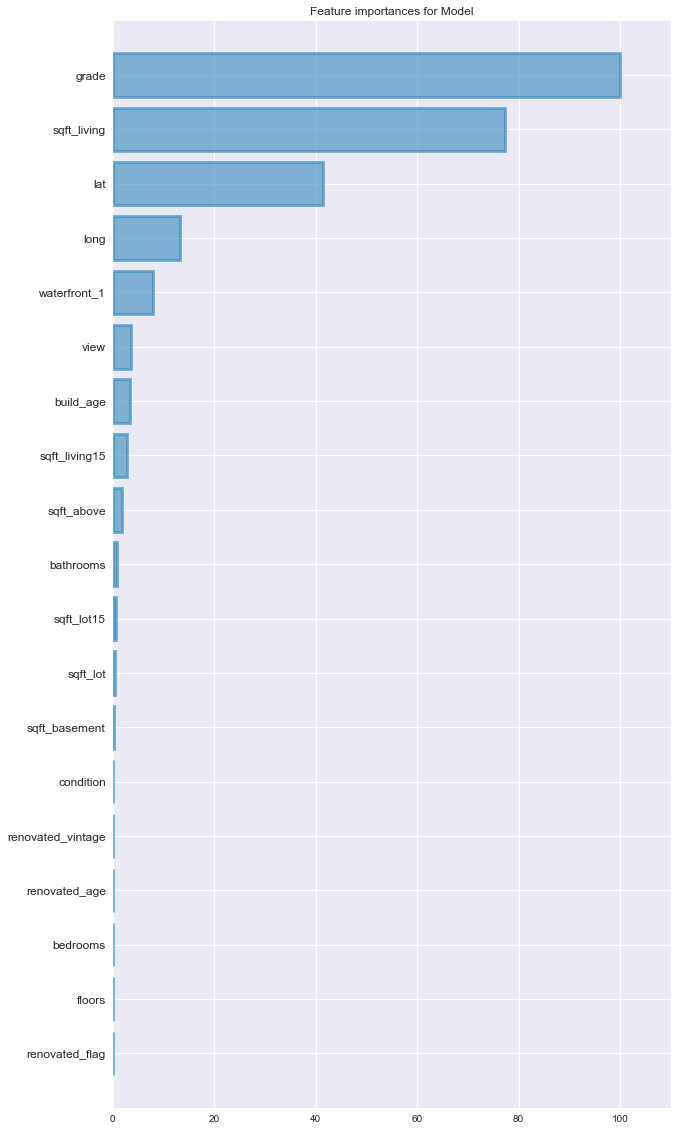

In [44]:
feature_importances_data = []
features = X_test.columns
for feature_name, feature_importance in zip(features,clf.best_estimator_.feature_importances_):
    feature_importances_data.append({
            'feature': feature_name,
            'importance': feature_importance
        })

feature_importances = pd.DataFrame(feature_importances_data)

feature_importances['abs_imp'] = feature_importances['importance'].apply(lambda x: abs(x))
feature_importances_sort = feature_importances.sort_values(by='abs_imp',ascending=False)
feature_importances_sort['relative_imp'] = 100.0 * (feature_importances_sort['abs_imp'] / feature_importances_sort['abs_imp'].max())
feature_importances_sort = feature_importances_sort[::-1].reset_index(drop=True)

plt.figure(figsize=(10, 20))
plt.title("Feature importances for Model")
plt.barh(feature_importances_sort.index, feature_importances_sort['relative_imp'],
         color='#348ABD', align="center", lw='3', edgecolor='#348ABD', alpha=0.6)
plt.yticks(feature_importances_sort.index, feature_importances_sort['feature'], fontsize=12,)
plt.ylim([-1, feature_importances_sort.index.max()+1])
plt.xlim([0, feature_importances_sort['relative_imp'].max()*1.1])
plt.show()

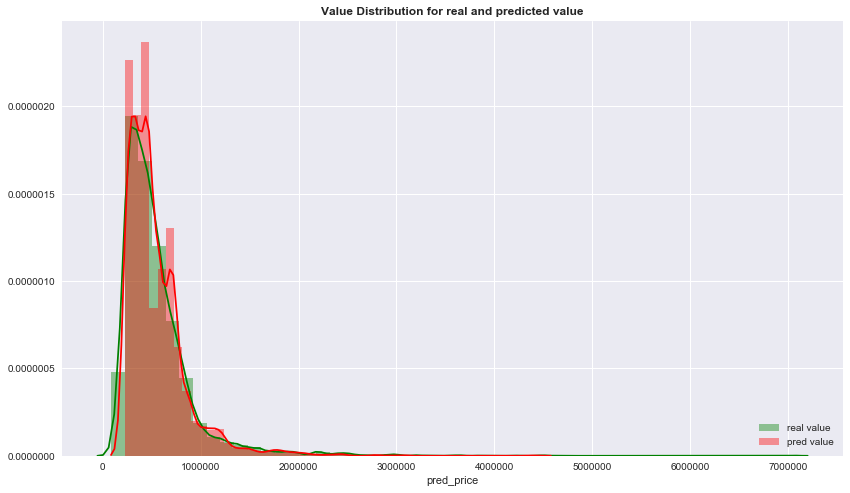

In [46]:
plt.figure(figsize=(14, 8))
plt.title('Value Distribution for real and predicted value', fontsize=12, fontweight="bold")
sns.distplot(results_test_rf.price, color='green',label='real value')
sns.distplot(results_test_rf.pred_price, color='red', label='pred value')
plt.legend(loc="lower right")

In [51]:
results_test_xgb.sort_values(by='price',ascending=False)

,id,price,pred_price
620,9808700762,7062500.0,4.736580e+06
4985,1924059029,4668000.0,4.758723e+06
3604,7738500731,4500000.0,3.433733e+06
5125,3835500195,4489000.0,3.212688e+06
2290,6065300370,4208000.0,3.392615e+06
2762,8106100105,3850000.0,3.442404e+06
2880,4217402115,3650000.0,3.128826e+06
1682,3625049042,3635000.0,3.480433e+06
1160,9253900271,3567000.0,2.955633e+06
1566,9362000040,3400000.0,2.890944e+06
